<a href="https://colab.research.google.com/github/zaidtas/EML-Assignment/blob/master/Flatnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import scipy.io as sio
import numpy as np
import os
from skimage.color import rgb2gray
import skimage.io
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from skimage.transform import resize as rsz
import torch.optim as optim
import os

from torch.utils import data
import torchvision.transforms as transforms
import skimage.transform
import copy

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class double_conv(nn.Module):
	'''(conv => BN => ReLU) * 2'''
	def __init__(self, in_ch, out_ch):
		super(double_conv, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_ch, out_ch, 3, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True),
			nn.Conv2d(out_ch, out_ch, 3, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True)
		)

	def forward(self, x):
		x = self.conv(x)
		return x

	
	
class double_conv2(nn.Module):
	'''(conv => BN => ReLU) * 2'''
	def __init__(self, in_ch, out_ch):
		super(double_conv2, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_ch, out_ch, 3,stride=2, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True),
			nn.Conv2d(out_ch, out_ch, 3, padding=1),
			nn.BatchNorm2d(out_ch,momentum=0.99),
			nn.ReLU(inplace=True)
		)

	def forward(self, x):
		x = self.conv(x)
		return x    

	
	

class inconv(nn.Module):
	def __init__(self, in_ch, out_ch):
		super(inconv, self).__init__()
		self.conv = double_conv(in_ch, out_ch)

	def forward(self, x):
		x = self.conv(x)
		return x


class down(nn.Module):
	def __init__(self, in_ch, out_ch):
		super(down, self).__init__()
		self.mpconv = nn.Sequential(
			double_conv2(in_ch, out_ch)
		)

	def forward(self, x):
		x = self.mpconv(x)
		return x


class up(nn.Module):
	def __init__(self, in_ch, out_ch, bilinear=False):
		super(up, self).__init__()

		if bilinear:
			self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
		else:
			self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

		self.conv = double_conv(in_ch, out_ch)

	def forward(self, x1, x2):
		x1 = self.up(x1)
		diffX = x1.size()[2] - x2.size()[2]
		diffY = x1.size()[3] - x2.size()[3]
		x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
						diffY // 2, int(diffY / 2)))
		x = torch.cat([x2, x1], dim=1)
		x = self.conv(x)
		return x


class outconv(nn.Module):
	def __init__(self, in_ch, out_ch):
		super(outconv, self).__init__()
		self.conv = nn.Conv2d(in_ch, out_ch, 3,padding=1)

	def forward(self, x):
		x = self.conv(x)
		return x


# In[7]:


def swish(x):
	return x * torch.sigmoid(x)

In [0]:

class FlatNet(nn.Module):
	def __init__(self, phil,phir,n_channels=4):
		super(FlatNet, self).__init__()
		self.inc = inconv(n_channels, 128)
		self.down1 = down(128, 256)
		self.down2 = down(256, 512)
		self.down3 = down(512, 1024)
		self.down4 = down(1024, 1024)
		self.up1 = up(2048, 512)
		self.up2 = up(1024, 256)
		self.up3 = up(512, 128)
		self.up4 = up(256, 128)
		self.outc = outconv(128, 3)
		self.PhiL =nn.Parameter(torch.tensor(phil)) 
		self.PhiR=nn.Parameter(torch.tensor(phir)) 
		self.bn=nn.BatchNorm2d(4,momentum=0.99)
	

	def forward(self, Xinp):
		
		X0=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,0,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
		X11=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,1,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
		X12=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,2,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
		X2=F.leaky_relu(torch.matmul(torch.matmul(Xinp[:,3,:,:],self.PhiR[:,:,0]).permute(0,2,1),self.PhiL[:,:,0]).permute(0,2,1).unsqueeze(3))
		Xout=torch.cat((X2,X12,X11,X0),3)
		x = Xout.permute(0,3,1,2)

		x = self.bn(x)
		x1 = self.inc(x)
		x2 = self.down1(x1)
		x3 = self.down2(x2)
		x4 = self.down3(x3)
		x5 = self.down4(x4)
		x = self.up1(x5, x4)
		x = self.up2(x, x3)
		x = self.up3(x, x2)
		x = self.up4(x, x1)
		x = self.outc(x)
		

			
		return torch.sigmoid(x)

In [0]:
f_model = '/content/gdrive/My Drive/Colab Notebooks/data/models/flatnet_new_transpose/latest.tar'
f_phil = '/content/gdrive/My Drive/Colab Notebooks/data/models/flatnet_new_transpose/phil_epoch14.npy'
f_phir = '/content/gdrive/My Drive/Colab Notebooks/data/models/flatnet_new_transpose/phir_epoch14.npy'

phil=np.load(f_phil)
phir=np.load(f_phir)



In [0]:

gen = FlatNet(phil,phir,4)





In [8]:
ckpt = torch.load(f_model,map_location=torch.device('cpu'))

gen.load_state_dict(ckpt['gen_state_dict'])

<All keys matched successfully>

In [0]:
def demosaic_raw(meas):
	tform = skimage.transform.SimilarityTransform(rotation=0.00174)
	X = meas.numpy()[0,:,:]
	X = X/65535.0
	X=X+0.003*np.random.randn(X.shape[0],X.shape[1]) #Adding a tiny amount of noise for robustness
	im1=np.zeros((512,640,4))
	im1[:,:,0]=X[0::2, 0::2]#b
	im1[:,:,1]=X[0::2, 1::2]#gb
	im1[:,:,2]=X[1::2, 0::2]#gr
	im1[:,:,3]=X[1::2, 1::2]#r
	im1=skimage.transform.warp(im1,tform)
	im=im1[6:506,10:630,:]      
	rowMeans = im.mean(axis=1, keepdims=True)
	colMeans = im.mean(axis=0, keepdims=True)
	allMean = rowMeans.mean()
	im = im - rowMeans - colMeans + allMean
	im = im.astype('float32')
	meas = torch.from_numpy(np.swapaxes(np.swapaxes(im,0,2),1,2)).unsqueeze(0)
	return meas[0,:,:,:]

In [0]:
import skimage as sk

In [14]:

f_meas = '/content/gdrive/My Drive/Colab Notebooks/data/images/meas/n02012849_220..png'
import torchvision
from PIL import Image

meas2=Image.open(f_meas)
print(type(meas2))

meas = sk.io.imread(f_meas)
meas=sk.img_as_float64(meas)
print(type(meas))
tf2=torchvision.transforms.ToTensor()
meas2=tf2(meas2)
print(meas2.shape)
print(type(meas2))
# skimage.io.imshow(meas)
# 
# meas = totensor(meas)

meas2 = demosaic_raw(meas2)
print(meas2.shape)



<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
torch.Size([1, 1024, 1280])
<class 'torch.Tensor'>
torch.Size([4, 500, 620])


In [15]:
print(type(meas2))
print(meas2.shape)


with torch.no_grad():
  out=gen(meas2.unsqueeze(0))


  

<class 'torch.Tensor'>
torch.Size([4, 500, 620])


(256, 256, 3)


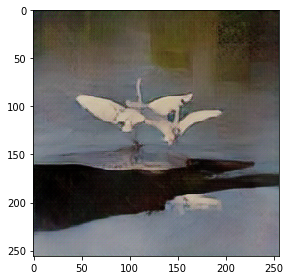

In [16]:
ims = out.detach().numpy()
ims = ims[0, :, :, :]
ims = np.swapaxes(np.swapaxes(ims,0,2),0,1)
print(ims.shape)
skimage.io.imshow(ims)
# ims = (ims-np.min(ims))/(np.max(ims)-np.min(ims))
# skimage.io.imsave(savedir+'/latest.png', ims)